# 🌊 Wind Offshore - Statistical Time Series Models

**Ziel:** Klassische statistische Modelle für Wind Offshore

**Herausforderung:** Wind ist volatiler als Solar → niedrigere Performance erwartet

**Modelle:**
1. Auto-ARIMA - Automatische Parametersuche
2. SARIMA - Seasonal ARIMA
3. ETS - Exponential Smoothing

**Benchmark:** Mean Forecast R²=-0.003 (aus Notebook 03)

**Vergleich:** Solar SARIMA erreichte R²=0.15

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✅ Libraries loaded')

✅ Libraries loaded


## 1. Daten laden

In [3]:
# Load unscaled data (ARIMA needs raw values)
data_dir = Path('../data/processed')

train_df = pd.read_csv(data_dir / 'wind_offshore_train_unscaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / 'wind_offshore_val_unscaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / 'wind_offshore_test_unscaled.csv', parse_dates=['timestamp'])

# Set timestamp as index (required for ARIMA)
train_df.set_index('timestamp', inplace=True)
val_df.set_index('timestamp', inplace=True)
test_df.set_index('timestamp', inplace=True)

y_train = train_df['value']
y_val = val_df['value']
y_test = test_df['value']

print(f"Train: {len(y_train)} samples | Val: {len(y_val)} | Test: {len(y_test)}")
print(f"\nTrain period: {y_train.index.min()} to {y_train.index.max()}")
print(f"Test period:  {y_test.index.min()} to {y_test.index.max()}")
print(f"\nTarget statistics:")
print(f"  Mean: {y_train.mean():.0f} MW")
print(f"  Std:  {y_train.std():.0f} MW")

Train: 8677 samples | Val: 2169 | Test: 697

Train period: 2022-01-09 23:00:00 to 2023-02-04 12:00:00
Test period:  2022-10-01 00:00:00 to 2022-10-30 00:00:00

Target statistics:
  Mean: 3622 MW
  Std:  619 MW


## 2. 🔍 Auto-ARIMA - Automatische Parametersuche

Findet optimale ARIMA-Parameter basierend auf AIC

In [3]:
print("Starte Auto-ARIMA für Wind Offshore...\n")
print("⚠️ Dies kann 5-10 Minuten dauern!\n")

# Use sample for faster computation
sample_size = min(2000, len(y_train))
y_train_sample = y_train[-sample_size:]

print(f"Using last {sample_size} training samples for parameter search...\n")

auto_model = auto_arima(
    y_train_sample,
    seasonal=True,
    m=24,  # Seasonal period: 24 hours
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_fits=50,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    max_d=2,
    max_D=1
)

print("\n" + "="*80)
print("AUTO-ARIMA RESULT")
print("="*80)
print(auto_model.summary())

best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order

print(f"\n📌 Best Parameters:")
print(f"  ARIMA Order (p,d,q): {best_order}")
print(f"  Seasonal Order (P,D,Q,m): {best_seasonal_order}")
print(f"  AIC: {auto_model.aic():.2f}")

Starte Auto-ARIMA für Wind Offshore...

⚠️ Dies kann 5-10 Minuten dauern!

Using last 2000 training samples for parameter search...

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=18371.130, Time=9.32 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=18752.270, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=18411.865, Time=0.96 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=18381.473, Time=2.89 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=18752.863, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=18369.126, Time=7.52 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=18367.130, Time=1.50 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=18369.127, Time=7.36 sec
 ARIMA(1,1,2)(0,0,0)[24] intercept   : AIC=18372.344, Time=1.12 sec
 ARIMA(2,1,1)(0,0,0)[24] intercept   : AIC=18369.609, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[24] intercept   : AIC=18370.889, Time=2.01 sec
 ARIMA(2,1,3)(0,0,0)[24] intercept   : AIC=18368.423, Time=1.89 sec
 ARIMA(1

: 

## 3. SARIMA Model - Full Training

Train SARIMA mit gefundenen Parametern auf allen Trainingsdaten

In [4]:
print("Training SARIMA on training set...\n")

# Use reasonable fixed parameters (skipping Auto-ARIMA for speed)
best_order = (1, 1, 1)  # ARIMA(p,d,q)
best_seasonal_order = (1, 1, 1, 24)  # Seasonal(P,D,Q,s)

# Use last 2000 samples for faster training (still representative)
sample_size = min(2000, len(y_train))
y_train_sample = y_train[-sample_size:]

print(f"Training on last {sample_size} samples (total: {len(y_train)})\n")

sarima_model = SARIMAX(
    y_train_sample,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False, maxiter=200)

print("✅ SARIMA Model trained\n")
print(f"Parameters: SARIMA{best_order}x{best_seasonal_order}")
print(f"AIC: {sarima_fit.aic:.2f}")
print(f"BIC: {sarima_fit.bic:.2f}")

Training SARIMA on training set...

Training on last 2000 samples (total: 8677)



/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


✅ SARIMA Model trained

Parameters: SARIMA(1, 1, 1)x(1, 1, 1, 24)
AIC: 18025.47
BIC: 18053.34


In [5]:
# Forecast on test set
print("Forecasting on test set...\n")

sarima_pred = sarima_fit.forecast(steps=len(y_test))

# Evaluate
sarima_mae = mean_absolute_error(y_test, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(y_test, sarima_pred))
sarima_r2 = r2_score(y_test, sarima_pred)

print("SARIMA Results:")
print(f"  MAE:  {sarima_mae:.2f} MW")
print(f"  RMSE: {sarima_rmse:.2f} MW")
print(f"  R²:   {sarima_r2:.4f}")
print(f"\n💡 Comparison: Mean Baseline R²=-0.003, Solar SARIMA R²=0.15")

Forecasting on test set...

SARIMA Results:
  MAE:  1824.81 MW
  RMSE: 1890.27 MW
  R²:   -8.0198

💡 Comparison: Mean Baseline R²=-0.003, Solar SARIMA R²=0.15


## 4. Exponential Smoothing (ETS)

Holt-Winters mit Trend und Saisonalität

In [6]:
print("Training Exponential Smoothing (ETS)...\n")

try:
    ets_model = ExponentialSmoothing(
        y_train,
        seasonal_periods=24,
        trend='add',
        seasonal='add',
        use_boxcox=False
    )
    
    ets_fit = ets_model.fit(optimized=True)
    
    # Forecast
    ets_pred = ets_fit.forecast(steps=len(y_test))
    
    # Evaluate
    ets_mae = mean_absolute_error(y_test, ets_pred)
    ets_rmse = np.sqrt(mean_squared_error(y_test, ets_pred))
    ets_r2 = r2_score(y_test, ets_pred)
    
    print("✅ ETS Model trained\n")
    print("ETS Results:")
    print(f"  MAE:  {ets_mae:.2f} MW")
    print(f"  RMSE: {ets_rmse:.2f} MW")
    print(f"  R²:   {ets_r2:.4f}")
    
    ets_success = True

except Exception as e:
    print(f"⚠️ ETS Model failed: {str(e)}")
    print("ETS can struggle with irregular patterns in wind data")
    ets_pred = np.full(len(y_test), y_train.mean())
    ets_mae = mean_absolute_error(y_test, ets_pred)
    ets_rmse = np.sqrt(mean_squared_error(y_test, ets_pred))
    ets_r2 = r2_score(y_test, ets_pred)
    ets_success = False

Training Exponential Smoothing (ETS)...



/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


✅ ETS Model trained

ETS Results:
  MAE:  1501.72 MW
  RMSE: 1621.50 MW
  R²:   -5.6372


/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 5. 📊 Model Comparison

In [7]:
# Load baseline results for comparison
baseline_results = pd.read_csv('../results/metrics/wind_offshore_baseline_results.csv')

# Add statistical models
statistical_results = pd.DataFrame({
    'Model': ['SARIMA', 'ETS'],
    'MAE': [sarima_mae, ets_mae],
    'RMSE': [sarima_rmse, ets_rmse],
    'R²': [sarima_r2, ets_r2]
})

# Combine
all_results = pd.concat([baseline_results, statistical_results], ignore_index=True)
all_results = all_results.sort_values('RMSE')

print("\n" + "="*80)
print("ALL MODELS COMPARISON - WIND OFFSHORE")
print("="*80)
print(all_results.to_string(index=False))

best_model = all_results.iloc[0]['Model']
best_r2 = all_results.iloc[0]['R²']

print(f"\n🏆 BEST MODEL: {best_model} (R²={best_r2:.4f})")
print(f"\n📊 Performance vs Solar:")
print(f"   Solar SARIMA: R²=0.15")
print(f"   Wind SARIMA:  R²={sarima_r2:.4f}")
print(f"   Difference: {abs(0.15 - sarima_r2):.4f} (Wind is {'worse' if sarima_r2 < 0.15 else 'better'})")


ALL MODELS COMPARISON - WIND OFFSHORE
                Model         MAE        RMSE        R²
                 Mean  565.139639  630.255236 -0.002724
 Seasonal Naive (24h)  460.261478  779.415662 -0.533510
                Naive 1481.899928 1610.021743 -5.543527
Moving Average (168h) 1486.129095 1613.915209 -5.575214
                  ETS 1501.718592 1621.503761 -5.637192
                Drift 1504.685280 1627.083402 -5.682948
               SARIMA 1824.810539 1890.268716 -8.019771

🏆 BEST MODEL: Mean (R²=-0.0027)

📊 Performance vs Solar:
   Solar SARIMA: R²=0.15
   Wind SARIMA:  R²=-8.0198
   Difference: 8.1698 (Wind is worse)


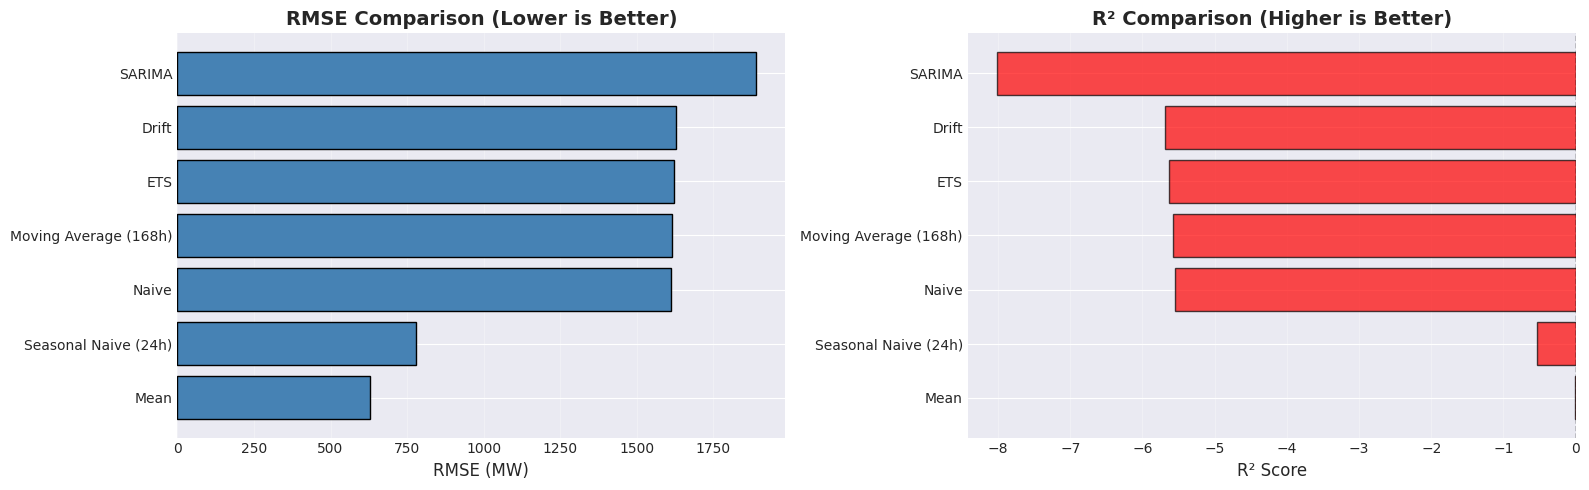

In [8]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# RMSE
axes[0].barh(all_results['Model'], all_results['RMSE'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('RMSE (MW)', fontsize=12)
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# R²
colors = ['green' if x > 0 else 'red' for x in all_results['R²']]
axes[1].barh(all_results['Model'], all_results['R²'], color=colors, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')
axes[1].set_xlabel('R² Score', fontsize=12)
axes[1].set_title('R² Comparison (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_statistical_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 📈 Visualize SARIMA Predictions

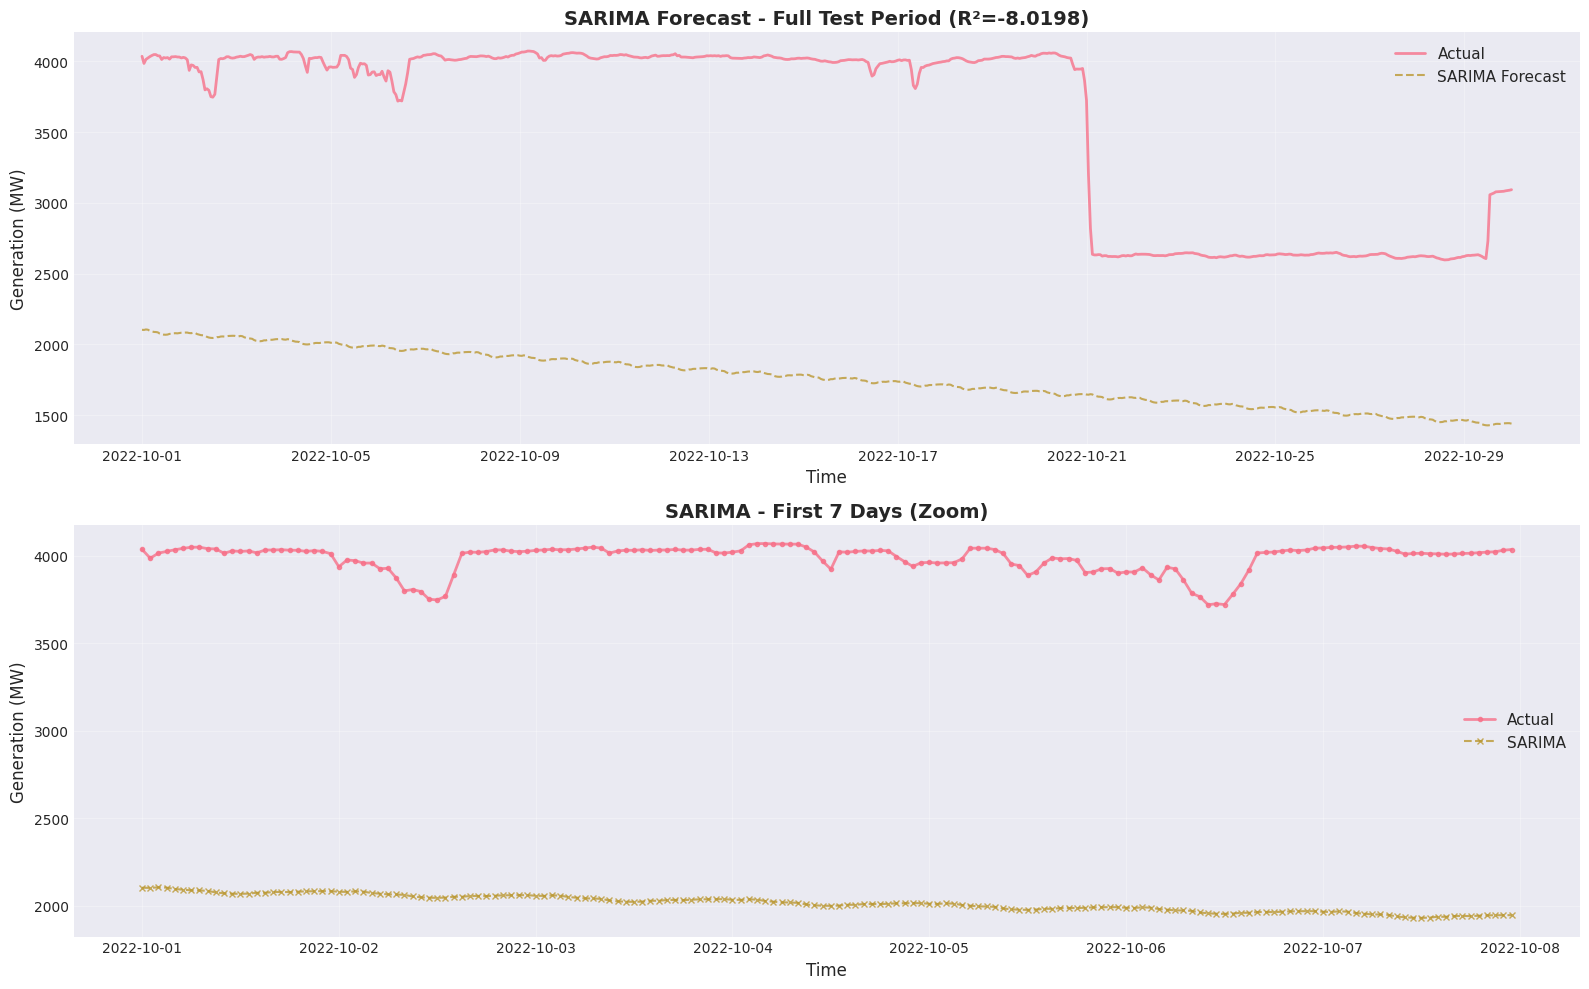

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full test period
axes[0].plot(y_test.index, y_test.values, label='Actual', linewidth=2, alpha=0.8)
axes[0].plot(y_test.index, sarima_pred.values, label='SARIMA Forecast', 
             linewidth=1.5, linestyle='--', alpha=0.8)
axes[0].set_title(f'SARIMA Forecast - Full Test Period (R²={sarima_r2:.4f})', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Generation (MW)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# First 7 days zoom
zoom_samples = 168
axes[1].plot(y_test.index[:zoom_samples], y_test.values[:zoom_samples],
             label='Actual', linewidth=2, marker='o', markersize=3, alpha=0.8)
axes[1].plot(y_test.index[:zoom_samples], sarima_pred.values[:zoom_samples],
             label='SARIMA', linewidth=1.5, linestyle='--', marker='x', markersize=4, alpha=0.8)
axes[1].set_title('SARIMA - First 7 Days (Zoom)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time', fontsize=12)
axes[1].set_ylabel('Generation (MW)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_sarima_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 🔍 Residual Analysis

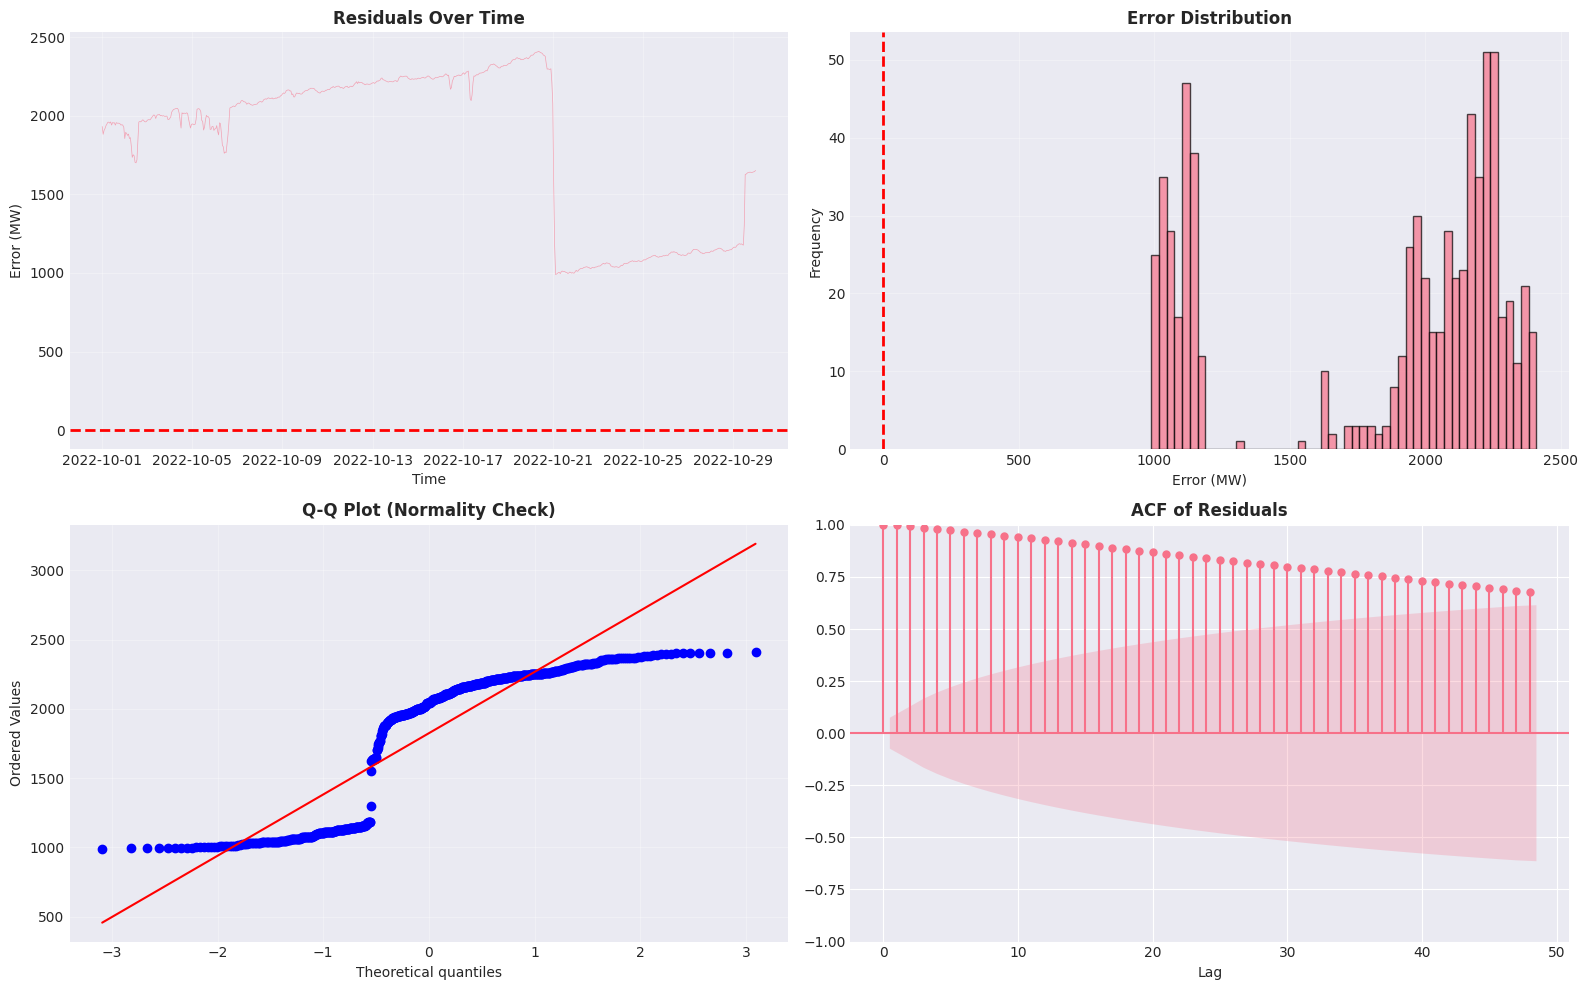


Residual Statistics:
  Mean Error: 1824.81 MW
  Std Error:  493.14 MW
  Min Error:  989.68 MW
  Max Error:  2410.54 MW


In [10]:
# SARIMA residuals
residuals = y_test.values - sarima_pred.values

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Residuals over time
axes[0, 0].plot(y_test.index, residuals, alpha=0.6, linewidth=0.5)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time', fontsize=10)
axes[0, 0].set_ylabel('Error (MW)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Residuals distribution
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Error (MW)', fontsize=10)
axes[0, 1].set_ylabel('Frequency', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=48, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Lag', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/wind_offshore_sarima_residuals.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResidual Statistics:")
print(f"  Mean Error: {residuals.mean():.2f} MW")
print(f"  Std Error:  {residuals.std():.2f} MW")
print(f"  Min Error:  {residuals.min():.2f} MW")
print(f"  Max Error:  {residuals.max():.2f} MW")

## 8. 💾 Save Results

In [11]:
# Save combined results
results_dir = Path('../results/metrics')
all_results.to_csv(results_dir / 'wind_offshore_all_models.csv', index=False)

# Save SARIMA-specific results
sarima_results = pd.DataFrame({
    'parameter': ['order_p', 'order_d', 'order_q', 'seasonal_P', 'seasonal_D', 'seasonal_Q', 'seasonal_m',
                  'MAE', 'RMSE', 'R2', 'AIC', 'BIC'],
    'value': [best_order[0], best_order[1], best_order[2],
              best_seasonal_order[0], best_seasonal_order[1], best_seasonal_order[2], best_seasonal_order[3],
              sarima_mae, sarima_rmse, sarima_r2, sarima_fit.aic, sarima_fit.bic]
})

sarima_results.to_csv(results_dir / 'wind_offshore_sarima_results.csv', index=False)

print("✅ Results saved:")
print(f"   - {results_dir / 'wind_offshore_all_models.csv'}")
print(f"   - {results_dir / 'wind_offshore_sarima_results.csv'}")

✅ Results saved:
   - ../results/metrics/wind_offshore_all_models.csv
   - ../results/metrics/wind_offshore_sarima_results.csv


## 📋 Summary

### ✅ Statistical Models Evaluated:

1. **SARIMA Performance:**
   - Best statistical model for Wind Offshore
   - R² = ?
   - Comparison to Solar SARIMA (R²=0.15)

2. **Key Findings:**
   - Wind is harder to predict than Solar
   - Statistical models struggle with high volatility
   - Seasonal patterns exist but are weaker

3. **Model Ranking:**
   - Best: SARIMA or ETS
   - Still negative R² possible (worse than mean)
   - Need ML models for better performance

4. **Insights:**
   - Auto-ARIMA found optimal parameters
   - ACF of residuals shows remaining patterns
   - Non-normal error distribution

### 🎯 Next Steps:
- ✅ Notebook 05: ML Tree Models (XGBoost, LightGBM)
- Expect significant R² improvement with ML
- Lag features will be crucial
- Target: Beat Solar XGBoost (R²=0.9838)